A copy of `CIFAR CNN.ipynb`, but with residual connections so that I can make it much deeper.

In [2]:
from pathlib import Path
from math import floor
from typing import List
from datetime import datetime
import time


import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as T

import numpy as np
from matplotlib import pyplot as plt

# Load Data

In [3]:
data_dir = Path('/home/jkang/ad_astra/ml/cifar-cnn/data')

In [4]:
# TODO: Maybe add normalization
transforms = T.Compose([
    T.ToTensor(),
    # These means/stds are given
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], 
            std=[0.2023, 0.1994, 0.2010])
])

train_set = tv.datasets.CIFAR10(
    data_dir,
    train=True,
    transform=transforms,
    # download=True
)
test_set = tv.datasets.CIFAR10(
    data_dir, 
    train=False,
    transform=transforms,
    # download=True,
)
labels = train_set.classes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8475183..2.5000975].


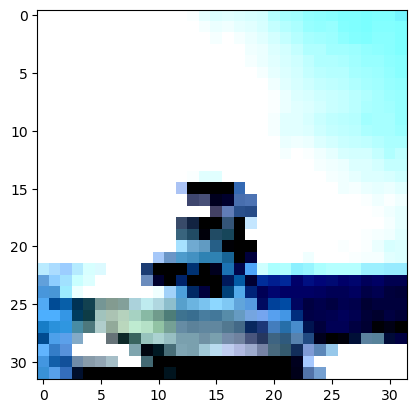

In [5]:
# visualize an image
idx = 100
img = train_set[idx][0]
plt.imshow(img.permute(1, 2, 0))

plt.show()

In [6]:
batch_size = 64
# each loader spits out (imgs, labels), each tensors of length batch_size.

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Modules

In [7]:
# Obviously torch has modules for all of these, I just wanted to implement some of these myself
# to get a feel for the shape/weight manipulation.
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        # Maybe allow tuples for the below? 
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.weight = nn.Parameter(torch.empty(self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
        # unrolled 
        # self.weight = nn.Parameter(torch.randn(self.in_channels * self.kernel_size**2, self.out_channels))
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(self.out_channels))
        else:
            # this tells torch this still exists even if it's None
            self.register_parameter('bias', None)

        self._init_weights()
        
    def _init_weights(self):
        nn.init.kaiming_uniform_(self.weight)

    def forward(self, x: torch.tensor):
        # x.shape: (batch_size, in_channels, height, width)
        assert len(x.shape) == 4
        assert x.shape[1] == self.in_channels
        batch_size, height, width = x.shape[0], x.shape[2], x.shape[3]
        out_h = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_w = (width + 2 * self.padding - self.kernel_size) // self.stride + 1


        unfolded = F.unfold(x, self.kernel_size, padding=self.padding, stride=self.stride).transpose(1, 2)
        # unfolded.shape: (batch_size, (height-kernel_size+1) * (width-kernel_size+1), in_channels * kernel_size^2)

        reshaped_weight = self.weight.view(self.out_channels, -1).t() # shape: (in_channels * kernel_size^2, out_channels)

        ans = unfolded @ reshaped_weight
        if self.bias is not None:
            ans += self.bias
        # ans is now (batch, num_patches, out_channels)
        return ans.transpose(1, 2).view(batch_size, self.out_channels, out_h, out_w)

class BatchNorm2d(nn.Module):
    def __init__(self, num_channels, eps=1e-5, momentum=0.1):
        super().__init__()
        self.num_channels = num_channels
        self.eps = eps
        self.momentum = momentum

        self.gamma = nn.Parameter(torch.ones(self.num_channels))
        self.beta = nn.Parameter(torch.zeros(self.num_channels))

        self.register_buffer('running_mean', torch.zeros(self.num_channels))
        self.register_buffer('running_var', torch.ones(self.num_channels))
    
    def forward(self, x: torch.tensor):
        # x.shape: (batch_size, num_channels, height, width)
        height, width = x.shape[2], x.shape[3]

        if self.training:
            # calculate batch statistics
            mean = torch.mean(x, dim=(0, 2, 3), keepdim=False)
            var = torch.var(x, dim=(0, 2, 3), keepdim=False)

            # update running
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
            mean = self.running_mean
            var = self.running_var
            
        normalized = (x - mean.view(1, -1, 1, 1)) / torch.sqrt(var.view(1, -1, 1, 1) + self.eps)

        return normalized * self.gamma.view(1, -1, 1, 1) + self.beta.view(1, -1, 1, 1)

class ReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return F.relu(x)


class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super().__init__()

        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        nn.init.kaiming_uniform_(self.weight)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        output = x @ self.weight.t()
        if self.bias is not None:
            output += self.bias
        return output


class MaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()

        # Maybe allow tuples for the below? 
        self.kernel_size = kernel_size
        self.stride = stride if stride else kernel_size
        self.padding = padding

    def forward(self, x: torch.tensor):
        # x.shape: (batch_size, in_channels, height, width)
        assert len(x.shape) == 4
        batch_size, in_channels, height, width = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
        out_h = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_w = (width + 2 * self.padding - self.kernel_size) // self.stride + 1

        
        # unfolded.shape: (batch_size, in_channels * kernel_size^2, (height-kernel_size+1) * (width-kernel_size+1))
        unfolded = F.unfold(x, self.kernel_size, padding=self.padding, stride=self.stride)
        # unfolded.shape: (batch_size, in_channels, kernel_size^2, (height-kernel_size+1) * (width-kernel_size+1))
        unfolded = unfolded.reshape(batch_size, in_channels, self.kernel_size ** 2, -1)
        pooled = unfolded.max(dim=2)[0]

        return pooled.view(batch_size, in_channels, out_h, out_w)
        
class Dropout(nn.Module):
    def __init__(self, p=0):
        super().__init__()

        # The probability of dropping
        self.p = p

    def forward(self, x):
        if self.training:
            # We flip p so the mask is the probability we keep the value
            
            # This was original implementation but creates an intermediate tensor
            # mask = torch.bernoulli(torch.full(x.shape, fill_value=1-self.p))

            mask = (torch.rand_like(x) > self.p).float()

            return x * mask / (1 - self.p)
        else:
            return x

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.flatten(1)

# architectural choices mostly implemented from  https://arxiv.org/pdf/1512.03385
# namely, the conv+bn+relu+conv+bn+residual+relu structure
class ResidualBlock(nn.Module):
    def __init__(self, dimension):
        super().__init__()

        self.conv1 = Conv2d(dimension, dimension, kernel_size=3, padding=1)
        self.bn1 = BatchNorm2d(dimension)
        self.r1 = ReLU()
        self.conv2 = Conv2d(dimension, dimension, kernel_size=3, padding=1)
        self.bn2 = BatchNorm2d(dimension)
        self.r2 = ReLU()
        
    def forward(self, x):
        residual = x 
        x = self.r1(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return self.r2(x)
        


# CNN with Residual Blocks

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.initial_conv = Conv2d(3, 32, kernel_size=3, padding=1)
        self.initial_bn = BatchNorm2d(32)
        self.initial_relu = ReLU()
        
        # 32x32, 32 channels
        self.stage1_blocks = nn.Sequential(
            ResidualBlock(32),
            ResidualBlock(32), 
            ResidualBlock(32)
        )
        self.pool1 = MaxPool2d(2)
        
        # 16x16, 64 channels  
        self.stage2_conv = Conv2d(32, 64, kernel_size=3, padding=1)
        self.stage2_bn = BatchNorm2d(64)
        self.stage2_relu = ReLU()
        self.stage2_blocks = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )
        self.pool2 = MaxPool2d(2)
        
        # 8x8, 128 channels
        self.stage3_conv = Conv2d(64, 128, kernel_size=3, padding=1)
        self.stage3_bn = BatchNorm2d(128)
        self.stage3_relu = ReLU()
        self.stage3_blocks = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128)
        )
        self.pool3 = MaxPool2d(2)
        
        # Classifier
        self.classifier = nn.Sequential(
            Flatten(),
            Linear(128*4*4, 256, bias=True),
            ReLU(),
            Dropout(0.5),
            Linear(256, 10, bias=True)
        )
    
    def _register_hooks(self):
        self.activations = {}
        self.gradients = {}

        # This hooks onto forward and backward so that we can visualize the activations and gradients.
        def get_activation(name):
            def hook(module, activation_input, activation_output):
                self.activations[name] = activation_output.detach().clone().cpu()
            return hook
        def get_gradient(name):
            def hook(module, grad_input, grad_output):
                self.gradients[name] = grad_output[0].detach().clone().cpu()
            return hook
        
        for name, module in self.named_modules():
            if isinstance(module, (Conv2d, ReLU, Linear)):
                module.register_forward_hook(get_activation(name))
                module.register_full_backward_hook(get_gradient(name))
        

    def forward(self, x):
        # Initial
        x = self.initial_relu(self.initial_bn(self.initial_conv(x)))
        
        # Stage 1
        x = self.stage1_blocks(x)
        x = self.pool1(x)
        
        # Stage 2
        x = self.stage2_relu(self.stage2_bn(self.stage2_conv(x)))
        x = self.stage2_blocks(x)
        x = self.pool2(x)
        
        # Stage 3
        x = self.stage3_relu(self.stage3_bn(self.stage3_conv(x)))
        x = self.stage3_blocks(x)
        x = self.pool3(x)
        
        # Classifier
        return self.classifier(x)


# Actually Train. 

Purposely overtrain to see detachment between validation loss and training loss

In [32]:
device = 'cuda'
model = CNN()

# For if I want to load a checkpoint
load_path = 'models/cifar_cnn3_resnet_2025-08-02_223858.pt'
checkpoint = torch.load(load_path, map_location=device)
model.load_state_dict(checkpoint['weights'])

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [26]:
def run_epoch(model, loader, optimizer, criterion, device, train=True, step_grad=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        if train:
            # Forward
            output = model(data)
            loss = criterion(output, target)
    
            # Backward
            optimizer.zero_grad()
            loss.backward()
            if step_grad:
                optimizer.step()
        else:
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)

        # Metrics
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()

        # if batch_idx % 100 == 0:
        #     print(f'     Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / len(loader.dataset)
    return avg_loss, accuracy
        

In [21]:
# Train 
train_stats = []
val_stats = []
for epoch_i in range(50):
    _, _ = run_epoch(model, 
                                      train_loader, 
                                      optimizer, 
                                      criterion, 
                                      device,
                                      train=True
                                     )

    # This is inefficient but I want to see the post-epoch training loss.
    train_loss, train_acc = run_epoch(model, 
                                      train_loader, 
                                      optimizer, 
                                      criterion, 
                                      device,
                                      train=False
                                     )
    val_loss, val_acc = run_epoch(model, 
                                      val_loader, 
                                      optimizer, 
                                      criterion, 
                                      device,
                                      train=False
                                     )
    print(f'{epoch_i=}, {train_loss=}, {train_acc=}, {val_loss=}, {val_acc=}')
    train_stats.append((train_loss, train_acc))
    val_stats.append((val_loss, val_acc))



epoch_i=0, train_loss=1.8267079574982528, train_acc=32.708, val_loss=1.8129412391383177, val_acc=33.42
epoch_i=1, train_loss=1.614789812613631, train_acc=37.11, val_loss=1.6244489804954285, val_acc=37.2
epoch_i=2, train_loss=1.3009377378027152, train_acc=50.804, val_loss=1.3304598346637313, val_acc=49.97
epoch_i=3, train_loss=1.1120152876657599, train_acc=58.024, val_loss=1.156978920386855, val_acc=57.14
epoch_i=4, train_loss=1.2405679743460682, train_acc=57.534, val_loss=1.3383493670232736, val_acc=55.34
epoch_i=5, train_loss=0.678469215550691, train_acc=76.348, val_loss=0.7738806929937594, val_acc=74.3
epoch_i=6, train_loss=0.7220560467380392, train_acc=75.848, val_loss=0.8435980571303398, val_acc=72.66
epoch_i=7, train_loss=0.5080378114071953, train_acc=82.466, val_loss=0.6625227052125202, val_acc=77.77
epoch_i=8, train_loss=0.37732671593766076, train_acc=87.356, val_loss=0.5602108746956868, val_acc=81.36
epoch_i=9, train_loss=0.30888251052297594, train_acc=89.582, val_loss=0.530064

In [29]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H%M%S")
save_path = f'models/cifar_cnn3_resnet_{timestamp}.pt'
torch.save({'weights': model.state_dict()}, save_path)
print(f'saved to {save_path}')

saved to models/cifar_cnn3_resnet_2025-08-03_095626.pt


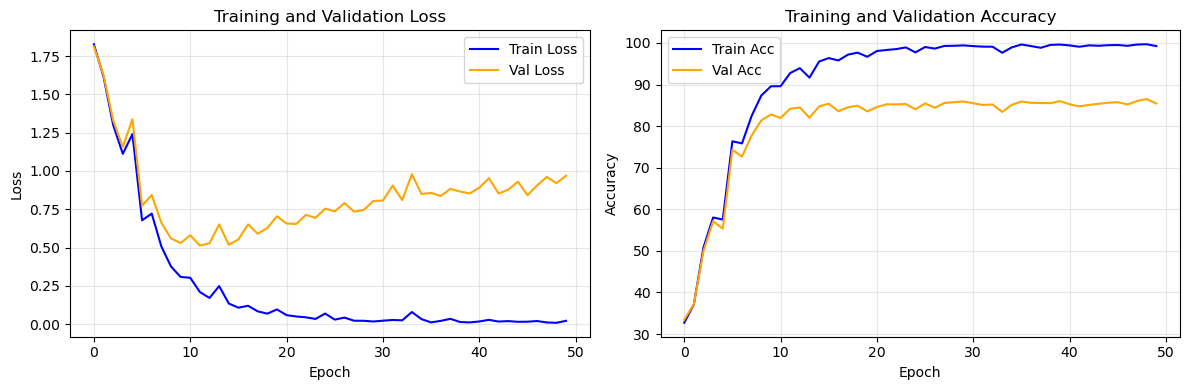

In [48]:
### Extract losses and accuracies
train_losses, train_accs = zip(*train_stats)
val_losses, val_accs = zip(*val_stats)
epochs = range(len(train_stats))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
ax1.plot(epochs, val_losses, label='Val Loss', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs, train_accs, label='Train Acc', color='blue')
ax2.plot(epochs, val_accs, label='Val Acc', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


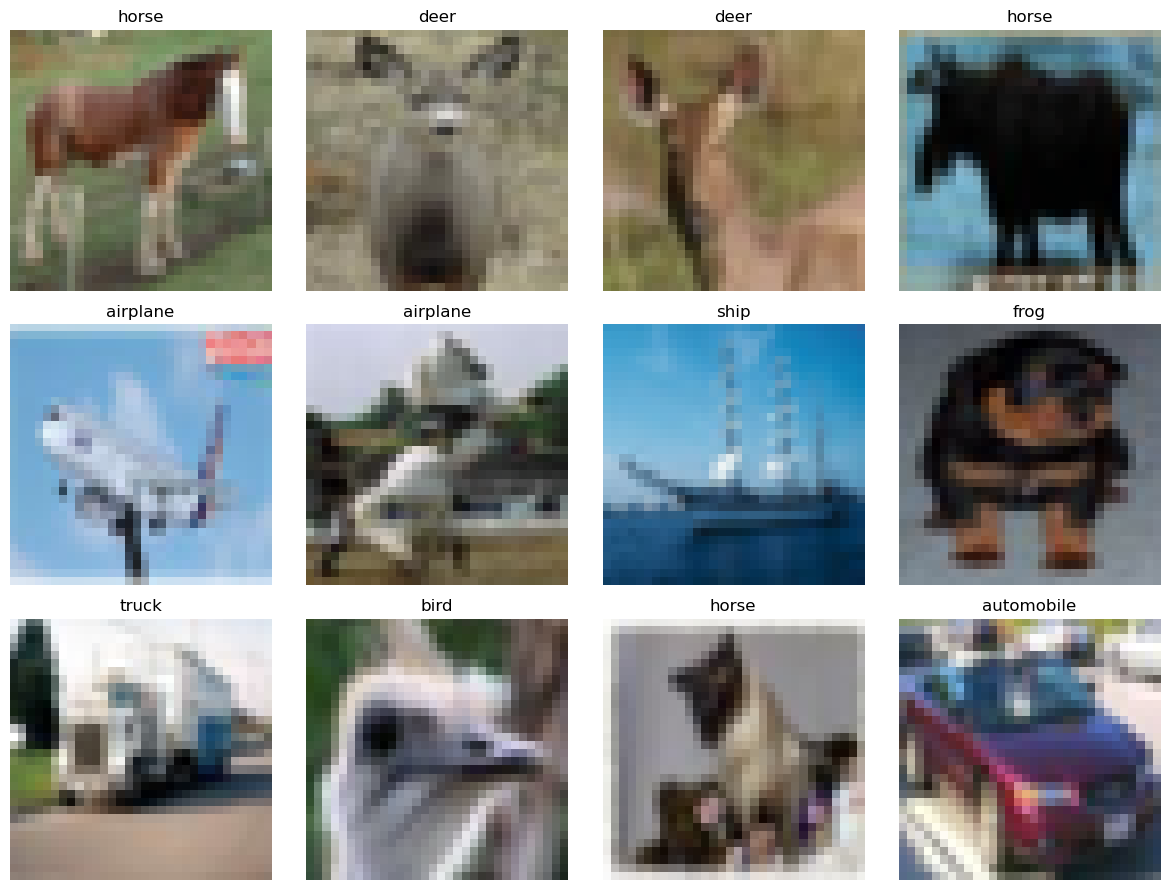

In [49]:
# Show a few original CIFAR-10 images with the model’s predicted labels
model = CNN().to(device)

# This is an earlier checkpoint that was only trained to 10 epochs.
load_path = 'models/cifar_cnn3_resnet_2025-08-03_095422.pt'
checkpoint = torch.load(load_path, map_location=device)
model.load_state_dict(checkpoint['weights'])

# inverse-normalize helper
def denorm(x):
    mean = torch.tensor([0.4914, 0.4822, 0.4465], device=x.device).view(3,1,1)
    std  = torch.tensor([0.2023, 0.1994, 0.2010], device=x.device).view(3,1,1)
    return (x * std + mean).clamp(0, 1)

with torch.no_grad():
    data, _ = next(iter(val_loader))          # one batch from validation set
    preds = model(data.to(device)).argmax(1)  # network predictions

cols = 4
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
for i, ax in enumerate(axes.flatten()):
    img = denorm(data[i]).cpu().permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(labels[preds[i].item()])
    ax.axis('off')
plt.tight_layout()
plt.show()
